VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a Variational RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from libs.vrnn_lib_sprites import seed_everything, VRNN
from libs.vrnn_lib_sprites import loss_function, train
from libs.vrnn_lib_sprites import BetaLinearScheduler, BetaThresholdScheduler
from libs.vrnn_lib_sprites import plot_losses, sample_predictions

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Modèle

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

où $d_x, d_z$ sont des MLP,

et où $h_t = \text{LSTM}(z_t, h_{t-1})$ est un forward LSTM qui encode $z_{1:t}$

et $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ est un forward LSTM qui encode $x_{1:t}$

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

où la première écriture est la stricte application de la chain rule.

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

Et:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

où $d_{\phi}$ est un MLP, et

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ est un backward LSTM qui encode $x_{t:T}$

# Implémentation de l'inférence

Il y a ici quelques choix d'implémentations différents de ceux du papier originel, et adapté au dataset **Sprites** :

- **trois** LSTMs distincts pour encoder $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$

- CNN2D pour PreEncoder et PostDecoder

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation dans le cas du VRNN est:

\begin{align}
    \begin{split}
    \mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T  \mathbb{E}{q_{\phi}(z_{1:t} \vert x_{1:T})} \log{p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t})} \\ &- \sum_{t=1}^T \mathbb{E}{q_{\phi}(z_{1:t-1} \vert x_{1:T})} \mathbb{KL}{q_{\phi}(z_t \vert z_{1:t-1}, x_{1:T})}{p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1})} 
    \end{split}    
\end{align}
<!-- 
Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align} -->

# Data

Dataset **Sprites** : https://arxiv.org/abs/1803.02991

Characters with 6 attributes (skin color, tops, pants and hairstyle), each taking 4 possibles values : $6**4 = 1296$ possibilities.

Performing 3 possibles actions (walking, casting spells and slashing) each with 3 possible view angles : 9 actions.

Total is 1296 x 9 = 11664 : 1000 for training, 296 for test.

In [5]:
from libs.load_sprites import sprites_act
import imageio.v2 as imageio

In [6]:
X_train, X_test, A_train, A_test, D_train, D_test = sprites_act('data/sprites/', return_labels=True)

walk front 0 0 0
walk left 0 1 1
walk right 0 2 2
spellcard front 1 0 3
spellcard left 1 1 4
spellcard right 1 2 5
slash front 2 0 6
slash left 2 1 7
slash right 2 2 8
A_test.shape: (2664, 8, 4, 6), D_test.shape: (2664, 8, 9), X_test.shape: (2664, 8, 64, 64, 3)
X_train.shape: (9000, 8, 64, 64, 3), X_test.min(): 0.0, X_test.max(): 0.99609375
data loaded in 2.30 seconds...


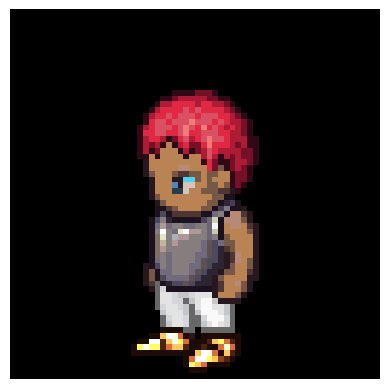

In [7]:
e = X_train[0,0,:]

plt.imshow(e)
plt.axis('off')
plt.show()

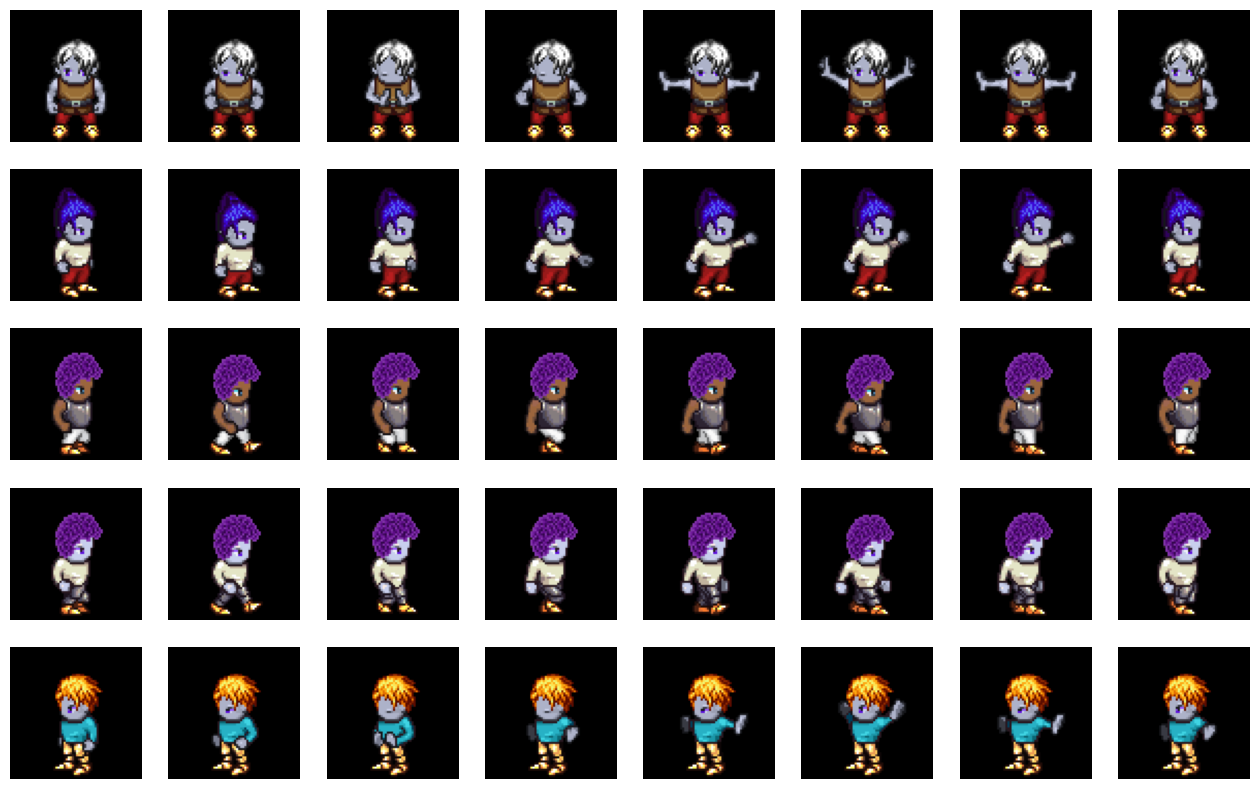

In [8]:
N = X_train.shape[0]
T = X_train.shape[1]
N_SAMPLES = 5

idx = np.random.choice(N, N_SAMPLES, replace=False)

fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=T, figsize=(T*2, N_SAMPLES*2))

for i, id_seq in enumerate(idx):
    images = X_train[id_seq]
    for t in range(T):
        ax[i, t].imshow(images[t])
        ax[i, t].axis('off')

Testing PreEncoder and PostDecoder

In [9]:
# test PreEncoderCNN : (T,B,64,64,3) -> (T,B,Dx)

from libs.vrnn_lib_sprites import PreEncoderCNN
pre_encoder = PreEncoderCNN(Dx=128).to(device)

test_in = torch.randn(10, 5, 64, 64, 3).to(device)  # (T, B, W, H, C)
output = pre_encoder(test_in)

print(f"Shape in = {test_in.shape}")
print(f"Shape out = {output.shape}")

Shape in = torch.Size([10, 5, 64, 64, 3])
Shape out = torch.Size([10, 5, 128])


In [10]:
# test PostDecoderCNN : (T,B,Dx) -> (T,B,64,64,3)

from libs.vrnn_lib_sprites import PostDecoderCNN
post_decoder = PostDecoderCNN(Dx=128).to(device)

test_in = torch.randn(10, 5, 128).to(device)  # (T, B, Dx)
output = post_decoder(test_in)

print(f"Shape in = {test_in.shape}")
print(f"Shape out = {output.shape}")  # Should be (T, B, 64, 64, 3)

Shape in = torch.Size([10, 5, 128])
Shape out = torch.Size([10, 5, 64, 64, 3])


# Dataset / Dataloader

In [11]:
# form datasets and dataloaders for PyTorch training
class CSRDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]
    
train_dataset = CSRDataset(X_train)
test_dataset = CSRDataset(X_test)

In [12]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VRNN Parameters

In [13]:
X_DIM = 128 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [14]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=128, latent_dim=32)
Bidirectional LSTM (input_size=128, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=32, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Latent State Transition MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Decoder MLP (x_dim=128, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Line

# Testing the pipeline

In [15]:
N = 10
# get data from dataloader
x = torch.tensor(X_train[:N, :, : ,: , :]).to(device)  # (B, T, W, H, C)
print(f"Shape of input out of X_train (batch {N} samples) = {x.shape}")

# get the right shape
x2 = x.permute(1,0,2,3,4)  # (T, B, W, H, C)
print(f"Shape of input after permute = {x2.shape}")

# preencode
x3 = pre_encoder(x2)  # (T, B, Dx)
print(f"Shape of input after preencoding = {x3.shape}")

# go through the VRNN
x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x3)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
print(f"Shape of input after VRNN : mu_x_t = {mu_x_t.shape}, logvar_x_t = {logvar_x_t.shape}")

# sample some x with Dx
sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
print(f"Shape of sampled x = {sampled_xs.shape}")

# decode the sampled x into images
x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
print(f"Shape of decoded x_hat = {x_hat.shape}")

# get the original shape back
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
print(f"Shape of x_hat after permute = {x_hat.shape}")

# loss
loss = (x - x_hat).pow(2).sum(dim=(2, 3, 4))  # (T, B)
loss = loss.mean(dim=(0, 1))  # (,)
print(f"Shape of loss = {loss.shape}, Loss value = {loss.item()}")

Shape of input out of X_train (batch 10 samples) = torch.Size([10, 8, 64, 64, 3])
Shape of input after permute = torch.Size([8, 10, 64, 64, 3])
Shape of input after preencoding = torch.Size([8, 10, 128])
Shape of input after VRNN : mu_x_t = torch.Size([8, 10, 128]), logvar_x_t = torch.Size([8, 10, 128])
Shape of sampled x = torch.Size([8, 10, 128])
Shape of decoded x_hat = torch.Size([8, 10, 64, 64, 3])
Shape of x_hat after permute = torch.Size([10, 8, 64, 64, 3])
Shape of loss = torch.Size([]), Loss value = 2535.085693359375


# Training loop

In [16]:
# One Training Step
def train_step(pre_encoder, vrnn, postdecoder, train_loader, learning_rate, criterion, optimizer):
    """Perform one training step on the chain of models:
    - get batch data
    - go through preencoder
    - go through vrnn
    - go through postdecoder
    - compute loss
    - backpropagate and update weights
    """
    
    # training mode
    pre_encoder.train()
    vrnn.train()
    post_decoder.train()
    
    # training loop
    rec_loss = 0.0
    kl_loss = 0.0
    epoch_loss = 0.0
    for x_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        x_batch = x_batch.to(device)  # Move batch to device
        # run the pipeline
        x_encoded = pre_encoder(x_batch.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
        # x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
        # sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
        # x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
        x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
        x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
        # compute the loss
        # _, kl, _ = loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t)
        kl = torch.tensor(0.0)  # Placeholder for KL divergence, as we are not using it in this example
        rec = (x_batch - x_hat).pow(2).sum(dim=(2, 3, 4))   # (T, B)
        rec = rec.mean(dim=(0, 1)) # (,)
        loss = kl + rec
        loss = rec
        # backpropagation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        # sum over batch
        rec_loss += rec.item()
        kl_loss += kl.item()
        epoch_loss += loss.item()
        print(f"(Training) - Batch Loss: {loss.item():.4f}, Reconstruction Loss: {rec.item():.4f}, KL Loss: {kl.item():.4f}", end='\r')
    
    # Average the losses over the entire epoch
    rec_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    epoch_loss /= len(train_loader)
        
    return pre_encoder, vrnn, post_decoder, rec_loss, kl_loss, epoch_loss

In [17]:
# One Test Step
def test_step(pre_encoder, vrnn, postdecoder, test_loader):
    """Perform one test step on the chain of models."""
    
    # mode evaluation
    pre_encoder.eval()
    vrnn.eval()
    post_decoder.eval()
    
    # testing loop
    rec_loss = 0.0
    kl_loss = 0.0
    epoch_loss = 0.0
    
    with torch.no_grad():
        for x_batch in test_loader:
            
            x_batch = x_batch.to(device)  # Move batch to device
            # run the pipeline
            x_encoded = pre_encoder(x_batch.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
            # x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
            # sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
            # x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
            x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
            x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)
            # compute the loss
            # _, kl, _ = loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t)
            kl = torch.tensor(0.0)  # Placeholder for KL divergence, as we are not using it in this example
            rec = (x_batch - x_hat).pow(2).sum(dim=(2, 3, 4))   # (T, B)
            rec = rec.mean(dim=(0, 1)) # (,)
            loss = kl + rec
            # sum over batch
            rec_loss += rec.item()
            kl_loss += kl.item()
            epoch_loss += loss.item()
            print(f"(Validation) - Batch Loss: {loss.item():.4f}, Reconstruction Loss: {rec.item():.4f}, KL Loss: {kl.item():.4f}", end='\r')
            
    # Average the losses over the entire epoch
    rec_loss /= len(test_loader)
    kl_loss /= len(test_loader)
    epoch_loss /= len(test_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [18]:
pre_encoder = PreEncoderCNN(Dx=X_DIM).to(device)
post_decoder = PostDecoderCNN(Dx=X_DIM).to(device)
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

# optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(list(pre_encoder.parameters()) + list(vrnn.parameters()) + list(post_decoder.parameters()), lr=learning_rate)

# loss
criterion = loss_function

In [19]:
# Early stopping class to prevent overfitting

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we accept with validation loss non decreasing
        self.patience = patience
        # tolerance for non decrease
        self.min_delta = min_delta
        # how many epochs without validation loss decrease
        self.counter = 0
        # minimum validation loss to beat
        self.min_validation_loss = float('inf')
        self.status = False

    def early_stop(self, validation_loss):
        # is the last validation loss better than the current minimum ?
        # status = True means stop training
        if validation_loss < self.min_validation_loss:
            # yes : update minimum value and reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.status = False
            # no : are we within tolerance ?
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # no : increase counter (losing patience)
            self.counter += 1
            # have we lost patience ?
            if self.counter >= self.patience:
                # yes
                self.status = True
            else:
                # no
                self.status = False

        return self.status, self.counter

patience = 10
early_stopper = EarlyStoppingCallback(patience, min_delta=1e-3)

In [20]:
n_epochs = 1000
stop = False

train_losses = []
test_losses = []
train_rec_losses = []
test_rec_losses = []
train_kl_losses = []
test_kl_losses = []

for epoch in range(n_epochs):
    
    # training and testing steps
    pre_encoder, vrnn, post_decoder, train_rec_loss, train_kl_loss, train_epoch_loss = train_step(pre_encoder, vrnn, post_decoder, train_loader, learning_rate, criterion, optimizer)
    test_rec_loss, test_kl_loss, test_epoch_loss = test_step(pre_encoder, vrnn, post_decoder, test_loader)
    
    # log losses
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)
    train_rec_losses.append(train_rec_loss)
    test_rec_losses.append(test_rec_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    
    # Early stopping check
    if early_stopper:
        stop, counter = early_stopper.early_stop(test_epoch_loss)
        if stop:
            msg = f'Early stopping at epoch {epoch+1} with counter {counter}'
            stop = True
        else:
            msg = f'Early stopping counter: {counter} / {early_stopper.patience}'
    
    # reporting        
    print(f'Epoch [{epoch+1:<6} .../... {n_epochs:<6}], Total Loss: {train_epoch_loss:.4e} (Train) {test_epoch_loss:.4e} (Val) -- KL Loss: {train_kl_loss:.4e} (train) {test_kl_loss:.4e} (test) -- Rec Loss: {train_rec_loss:.4e} (train) {test_rec_loss:.4e} (test) -- {msg}')
    if stop:
        print("Early stopping triggered. Stopping training.")
        break

Epoch [1      .../... 1000  ], Total Loss: 1.7019e+03 (Train) 4.6838e+02 (Val) -- KL Loss: 0.0000e+00 (train) 0.0000e+00 (test) -- Rec Loss: 1.7019e+03 (train) 4.6838e+02 (test) -- Early stopping counter: 0 / 10
Epoch [2      .../... 1000  ], Total Loss: 3.7957e+02 (Train) 3.4907e+02 (Val) -- KL Loss: 0.0000e+00 (train) 0.0000e+00 (test) -- Rec Loss: 3.7957e+02 (train) 3.4907e+02 (test) -- Early stopping counter: 0 / 10
Epoch [3      .../... 1000  ], Total Loss: 3.3796e+02 (Train) 3.2551e+02 (Val) -- KL Loss: 0.0000e+00 (train) 0.0000e+00 (test) -- Rec Loss: 3.3796e+02 (train) 3.2551e+02 (test) -- Early stopping counter: 0 / 10
Epoch [4      .../... 1000  ], Total Loss: 3.1908e+02 (Train) 3.1104e+02 (Val) -- KL Loss: 0.0000e+00 (train) 0.0000e+00 (test) -- Rec Loss: 3.1908e+02 (train) 3.1104e+02 (test) -- Early stopping counter: 0 / 10
Epoch [5      .../... 1000  ], Total Loss: 3.0801e+02 (Train) 3.0253e+02 (Val) -- KL Loss: 0.0000e+00 (train) 0.0000e+00 (test) -- Rec Loss: 3.0801e+02 

# Plot losses

/tmp/ipykernel_4182071/301023725.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale('log')  # Log scale for better visibility


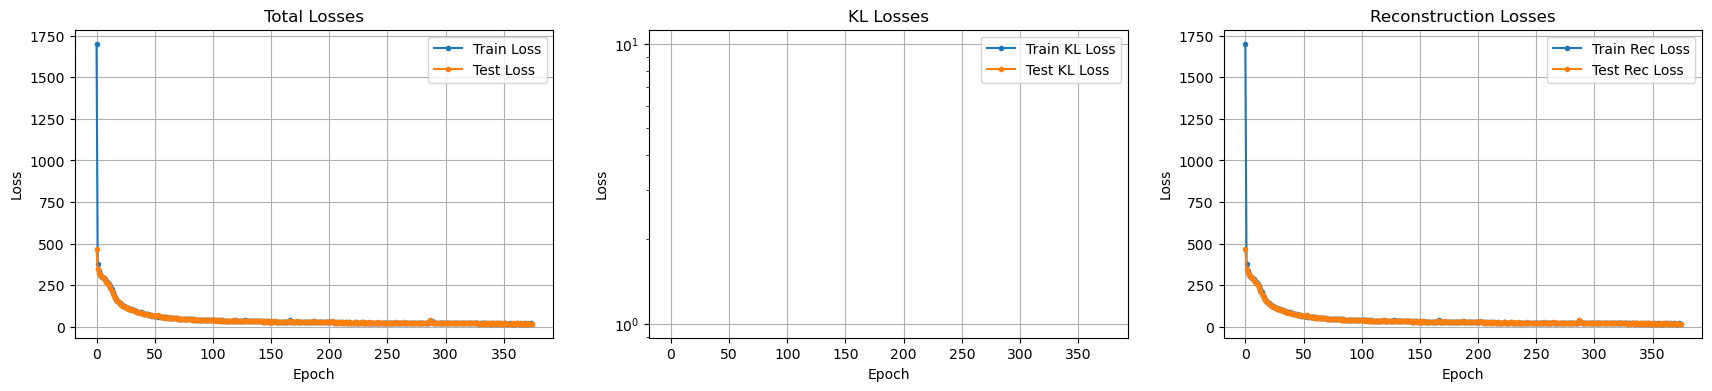

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 4))

# plot total losses
ax[0].plot(train_losses, label='Train Loss', marker='.')
ax[0].plot(test_losses, label='Test Loss', marker='.')
ax[0].set_title('Total Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# plot kl losses
ax[1].plot(train_kl_losses, label='Train KL Loss', marker='.')
ax[1].plot(test_kl_losses, label='Test KL Loss', marker='.')
ax[1].set_title('KL Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')   
ax[1].set_yscale('log')  # Log scale for better visibility 
ax[1].legend()
ax[1].grid(True)

# plot reconstrcution losses
ax[2].plot(train_rec_losses, label='Train Rec Loss', marker='.')
ax[2].plot(test_rec_losses, label='Test Rec Loss', marker='.')
ax[2].set_title('Reconstruction Losses')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
ax[2].grid(True)

# Some visualisation - reconstruction

In [22]:
N_SAMPLES = 5

idx = np.random.choice(X_test.shape[0], N_SAMPLES, replace=False)

images = torch.tensor(X_test[idx]).to(device)

x_encoded = pre_encoder(images.permute(1, 0, 2, 3, 4).to(device))  # (T, B, Dx)
# x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = vrnn(x_encoded)  # mu_x_t (T,B,Dx), logvar_x_t (T,B,Dx)
# sampled_xs = mu_x_t + torch.randn_like(mu_x_t) * torch.exp(0.5 * logvar_x_t)  # (T, B, Dx)
# x_hat = post_decoder(sampled_xs)  # (T, B, 64, 64, 3)
x_hat = post_decoder(x_encoded)  # (T, B, 64, 64, 3)  ND - AE SEULEMENT !!
x_hat = x_hat.permute(1, 0, 2, 3, 4)  # (B, T, W, H, C)

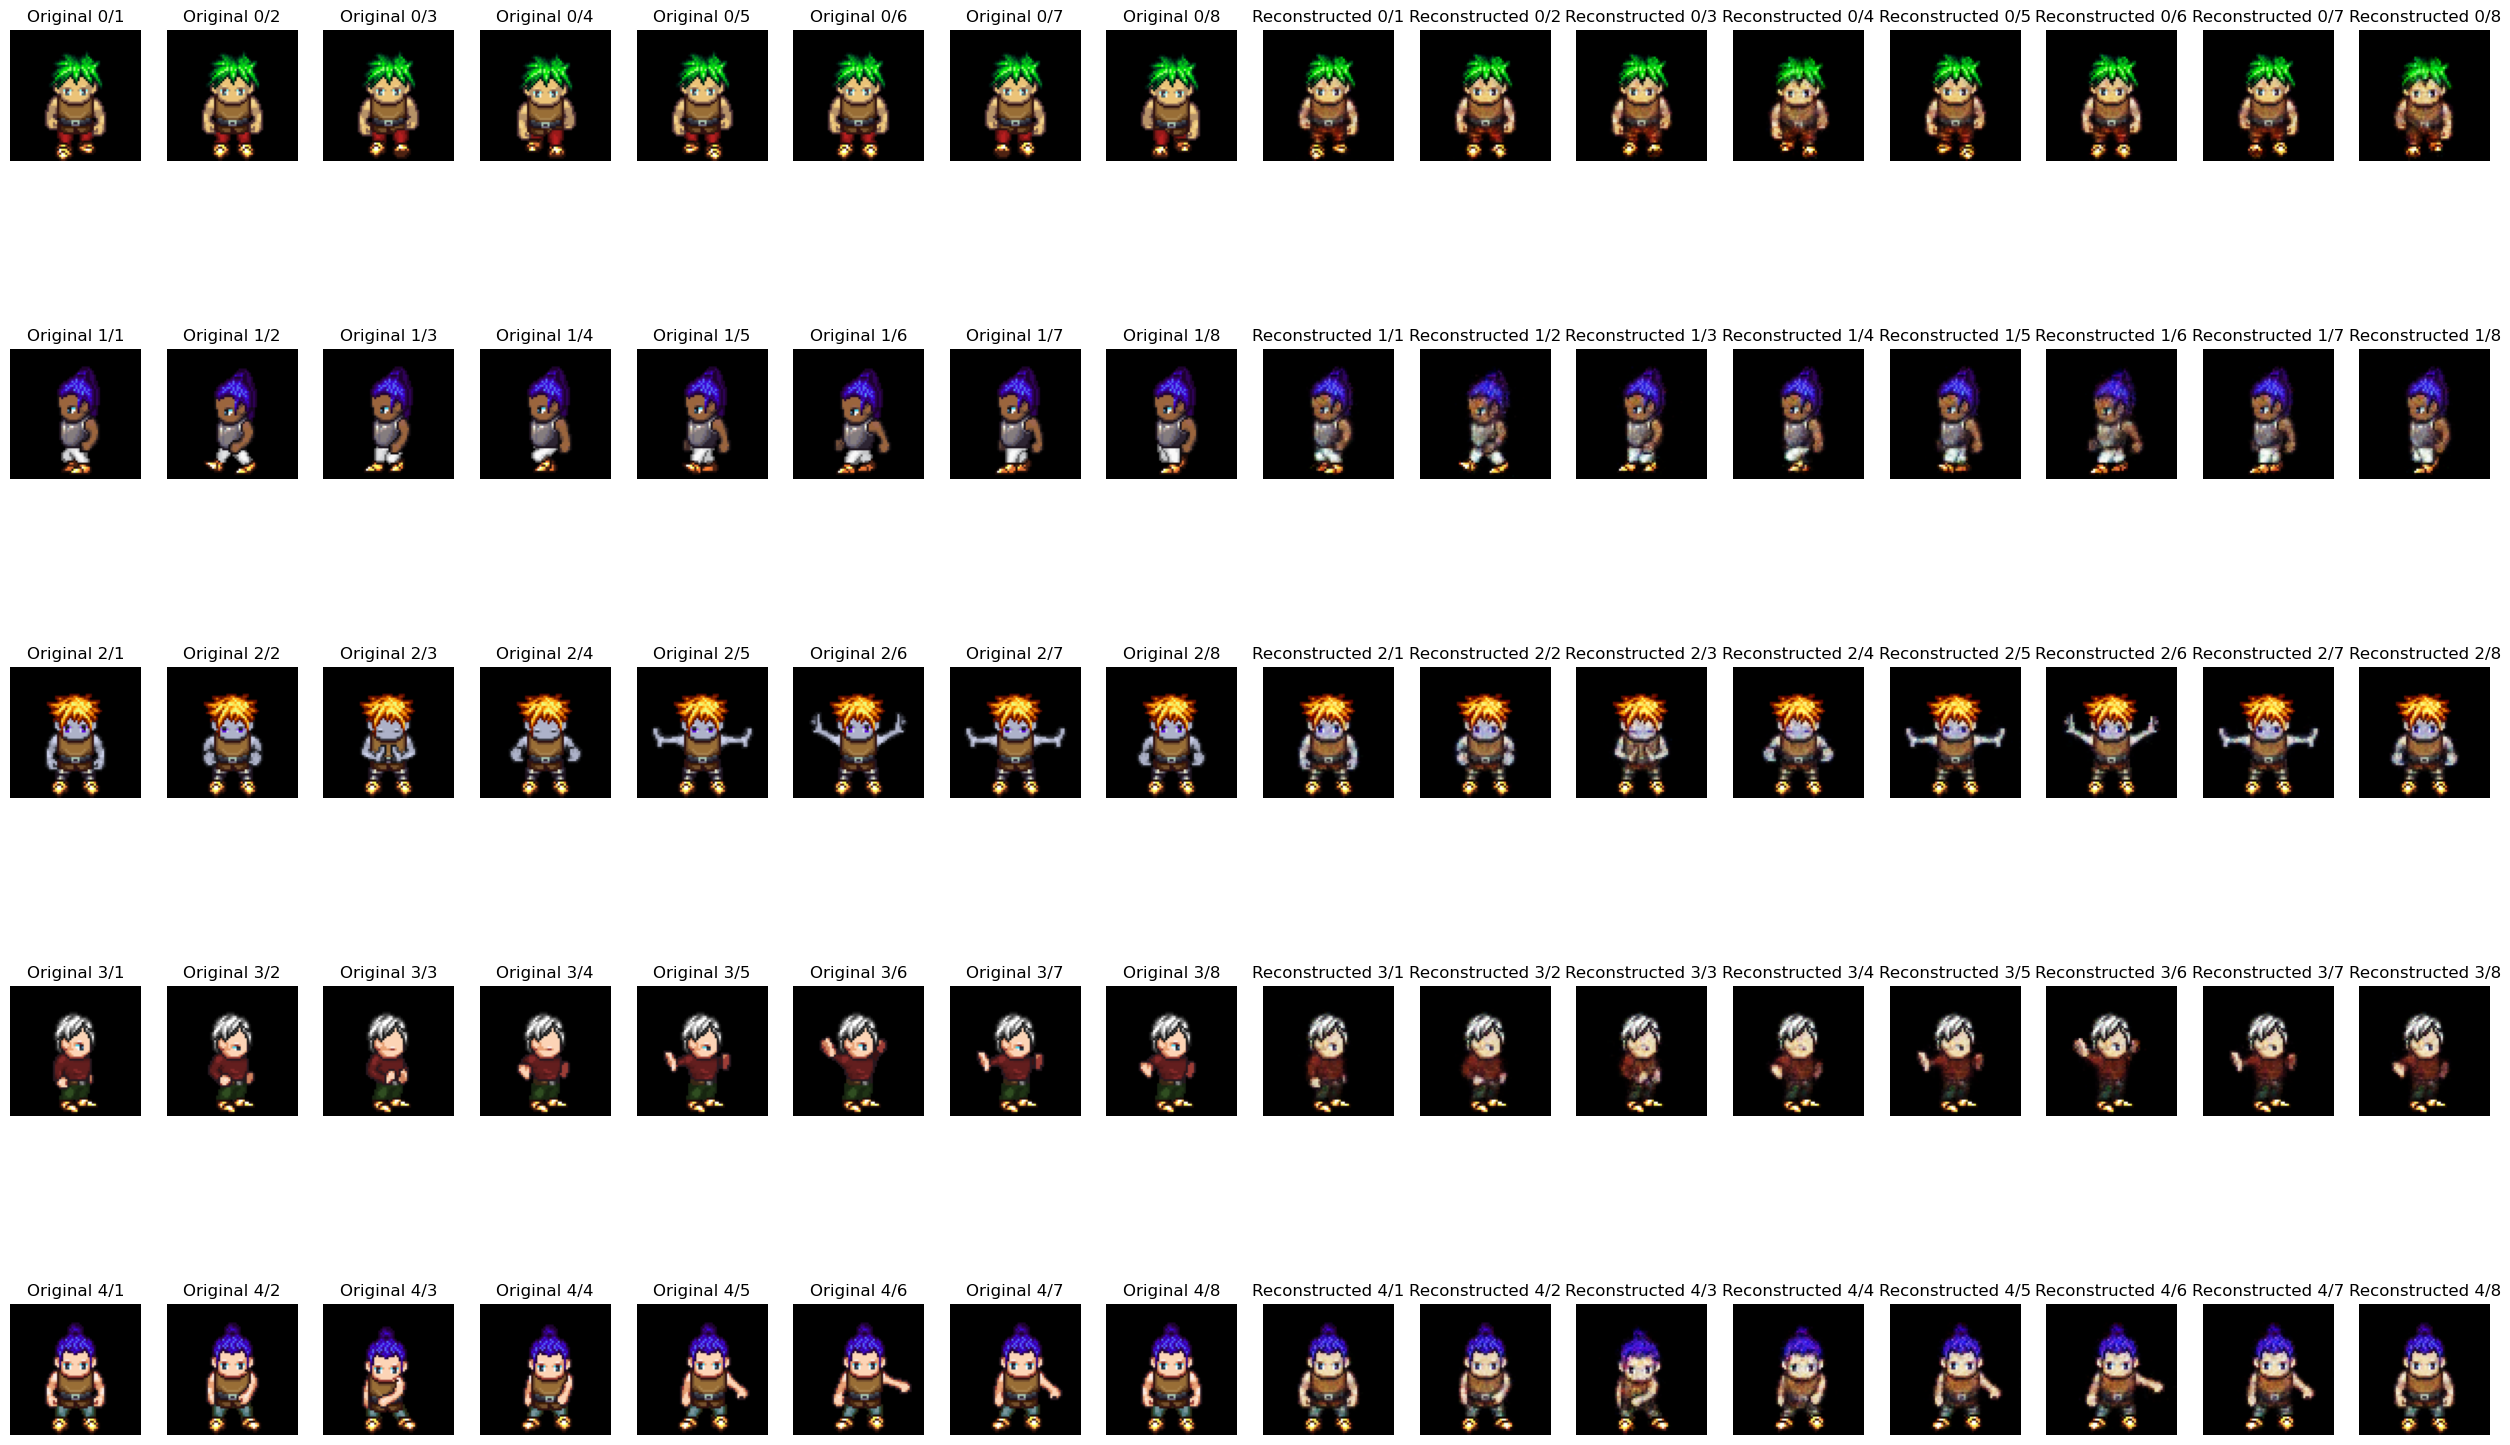

In [26]:
T = x_hat.shape[1]  # Number of time steps
fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=2*T, figsize=(32, 4 * N_SAMPLES))
for i, id_seq in enumerate(idx):

    for j in range(X_test.shape[1]):
        # Original images
        ax[i, j].imshow(images[i, j].cpu().numpy())
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Original {i}/{j+1}')
        
        # Reconstructed images
        ax[i, T+j].imshow(x_hat[i, j].detach().cpu().numpy())
        ax[i, T+j].axis('off')
        ax[i, T+j].set_title(f'Reconstructed {i}/{j+1}')